In [3]:
import sys  
sys.path.insert(0, '../')
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import json
import os
import time
from argparse import ArgumentParser
from tools.datasets import ImageNet, ImageNet9
from tools.model_utils import make_and_restore_model, eval_model
from tools.folder import pil_loader
from PIL import Image
import tqdm

from matplotlib import pyplot as plt

In [71]:
lr = []
n_cycle = 5
n_epoch_cycle = 5

learning_rate = 1e-4

for truc in range(10) :
    lr.append(learning_rate)
    
for truc in range(10) :
    lr.append(learning_rate)
    learning_rate*= 0.9 #constant because we fix the "amplitude of the cycles"
    
lr.append(learning_rate)

for cycle in range(n_cycle) :
    learning_rate /= np.power(0.9,5) #constant because we fix the "amplitude of the cycles"

    for epoch in range(n_epoch_cycle) :
        lr.append(learning_rate)
        learning_rate *= np.power(0.9,5/(n_epoch_cycle-1)) #the vitess of decreasing of the learning rate depends of the number of cycle
    learning_rate /= np.power(0.9,5/(n_epoch_cycle-1))


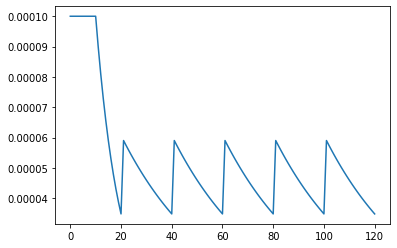

In [70]:
plt.plot(range(len(lr)),lr)

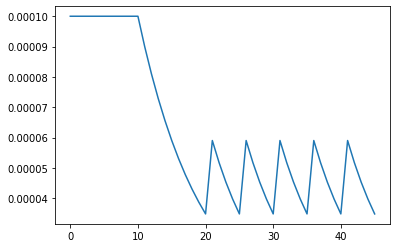

In [72]:
plt.plot(range(len(lr)),lr)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 16
workers = 0
variation = "original"
arch="resnet50"
dataset = ImageNet9("../data/"+variation)
checkpoint = "../models\in9l_resnet50.pt"
val_loader = ImageNet9("..\data\original").make_loaders(batch_size=batch_size, workers=workers)
train_loader = ImageNet9("..\data\original").make_loaders(batch_size=batch_size, workers=workers, test = False)

==> Preparing dataset ImageNet9..
==> Preparing dataset ImageNet9..


In [ ]:
train_loader

In [4]:
n_classes = 9
def l_2_onehot(labels,nb_digits=n_classes):
    # take labels (from the dataloader) and return labels onehot-encoded
    #
    # your code here
    #
    label_onehot = torch.FloatTensor(labels.shape[0], nb_digits)
    label_onehot.zero_()
    label_onehot = label_onehot.scatter_(1,labels.unsqueeze(1),1).cpu()

    return label_onehot

In [5]:
model_checkpoint,_ = make_and_restore_model(arch=arch, dataset=dataset,
                     resume_path=checkpoint) 

=> loading checkpoint '../models\in9l_resnet50.pt'
=> loaded checkpoint '../models\in9l_resnet50.pt' (epoch 156)


In [6]:
model_checkpoint.cuda()
model_checkpoint.eval()
model_checkpoint = nn.DataParallel(model_checkpoint)

In [7]:
map_to_in9 = {}
with open('../in_to_in9.json', 'r') as f:
    map_to_in9.update(json.load(f))

In [8]:
#prec1 = eval_model(val_loader, model_checkpoint, map_to_in9, map_in_to_in9=False)
#print(f'Accuracy on {variation} is {prec1*100:.2f}%')

In [9]:
model, _ = make_and_restore_model(arch=arch, dataset=dataset,
                     pytorch_pretrained=True)

In [10]:
model.fc = nn.Linear(2048, 9)
model.model.fc = nn.Linear(2048, 9)

In [11]:
model.to(device)

NormalizedModel(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


train_correct = 0
train_loss = 0
correct = 0
# loop per epoch 
for i, (inp, target) in enumerate(train_loader):
    output = model(inp.to(device)).cpu()
    pred = output.argmax(dim=1).cpu()
    correct += (pred==target).sum().item()
print("Initial Accuracy : ", correct/len(train_loader.dataset))

for epoch in tqdm.tqdm_notebook(range(10)):
    train_correct = 0
    train_loss = 0
    print('Epoch {}'.format(epoch+1))
    correct = 0
    # loop per epoch 
    for i, (inp, target) in enumerate(train_loader):
        output = model(inp.to(device)).cpu()
        
        loss = criterion(output, l_2_onehot(target))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1).cpu()
        correct += (pred==target).sum().item()
        train_loss += loss
    print("Accuracy : ", correct/len(train_loader.dataset))
    print("Train loss : ", train_loss.item())
print('End of training.\n')

Initial Accuracy :  0.10790123456790124


<ipython-input-12-a686099a7a28>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(10)):


Epoch 1
Accuracy :  0.30765432098765433
Train loss :  538.9517211914062
Epoch 2
Accuracy :  0.004691358024691358
Train loss :  653.385498046875
Epoch 3
Accuracy :  0.011358024691358024
Train loss :  638.86767578125
Epoch 4
Accuracy :  0.0
Train loss :  645.482666015625
Epoch 5
Accuracy :  0.0004938271604938272
Train loss :  644.7195434570312
Epoch 6
Accuracy :  0.0004938271604938272
Train loss :  643.7118530273438
Epoch 7



KeyboardInterrupt: 